<a href="https://colab.research.google.com/github/abhinav-exp/Forecasting-CryptoCurrency-Prices/blob/master/CFLANN_with_JAYA-trained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
GitHubDataLink = 'https://raw.githubusercontent.com/abhinav-exp/Forecasting-CryptoCurrency-Prices/master/Datasets/'
InputFileLink = GitHubDataLink + 'DataBTC2017.csv'
data1 = pd.read_csv(InputFileLink, header=0, index_col=0)
print(data1)

            CBBTCUSD
DATE                
2017-06-18   2515.25
2017-06-19   2596.98
2017-06-20   2725.08
2017-06-21   2643.35
2017-06-22   2679.99
...              ...
2019-08-03  10820.75
2019-08-04  10997.82
2019-08-05  11775.14
2019-08-06  11440.08
2019-08-07  12014.41

[781 rows x 1 columns]


In [3]:
data1min = data1.min()
data1max = data1.max()

normalize = lambda x: (x - data1min + 1)/(data1max - data1min + 2)
data2 = normalize(data1)
print(data2)

            CBBTCUSD
DATE                
2017-06-18  0.034073
2017-06-19  0.038680
2017-06-20  0.045901
2017-06-21  0.041294
2017-06-22  0.043360
...              ...
2019-08-03  0.502247
2019-08-04  0.512228
2019-08-05  0.556045
2019-08-06  0.537158
2019-08-07  0.569532

[781 rows x 1 columns]


In [4]:
def split_sequence(sequence, n_steps):
  X= list()
  for i in range(len(sequence) - n_steps):
    end_ix = i + n_steps
    seq_x= sequence.values[i:end_ix, 0]
    X.append(seq_x) 
  return pd.DataFrame(X)

data3 = split_sequence(data2, 10)
print(data3.shape)
print(data3)

(771, 10)
            0         1         2         3         4         5         6  \
0    0.034073  0.038680  0.045901  0.041294  0.043360  0.043967  0.037432   
1    0.038680  0.045901  0.041294  0.043360  0.043967  0.037432  0.033530   
2    0.045901  0.041294  0.043360  0.043967  0.037432  0.033530  0.028023   
3    0.041294  0.043360  0.043967  0.037432  0.033530  0.028023  0.037484   
4    0.043360  0.043967  0.037432  0.033530  0.028023  0.037484  0.036208   
..        ...       ...       ...       ...       ...       ...       ...   
766  0.441959  0.449255  0.447073  0.426045  0.430599  0.427984  0.432307   
767  0.449255  0.447073  0.426045  0.430599  0.427984  0.432307  0.461562   
768  0.447073  0.426045  0.430599  0.427984  0.432307  0.461562  0.479501   
769  0.426045  0.430599  0.427984  0.432307  0.461562  0.479501  0.486030   
770  0.430599  0.427984  0.432307  0.461562  0.479501  0.486030  0.502247   

            7         8         9  
0    0.033530  0.028023  0.03

In [5]:
train_x = data3.iloc[:int(0.85*len(data2)), :9]
train_y = data3.iloc[:int(0.85*len(data2)), 9:10]
test_x = data3.iloc[int(0.85*len(data2)):, :9]
test_y = data3.iloc[int(0.85*len(data2)):, 9:10]
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(663, 9)
(663, 1)
(108, 9)
(108, 1)


In [6]:
class CFLANN():
  def __init__(self, learn_rate, W):
    self.learning_rate = learn_rate
    self.weight_matrix = W
  
  def func_x(self, x):
    const_x = np.ones((len(x), 1))
    orginal_x = x
    func1_x = 2*(x ** 2) - 1
    func2_x = 4*(x ** 3) - 3*x
    func3_x = 8*(x ** 4) - 8*(x ** 2) + 1
    functioned_x = np.hstack((x, func1_x, func2_x, func3_x, const_x))
    return functioned_x

  def tanh_derivative(self, x):
    return 1.0 - (np.tanh(x) ** 2)

  def forward_propagation(self, x):
    funced_x = self.func_x(x)
    return np.tanh(np.dot(funced_x, self.weight_matrix))

  def train(self, train_x, train_y, epochs):
    self.me_curve = np.array([])
    for iteration in range(epochs):
      y = self.forward_propagation(train_x)

      error = train_y - y

      adjustment=np.dot(self.learning_rate*self.func_x(train_x).T,error*self.tanh_derivative(y))

      self.weight_matrix += adjustment
      self.me_curve = np.append(self.me_curve, np.mean(error[9]**2))

In [14]:
find_mse = lambda x , y: np.mean((x - y) ** 2)

class JAYATFLANN():
  def __init__(self, p_size):
    self.p_size = p_size
    self.data = []
    self.error_curve = []

    for i in range(p_size):
      print(i)
      d = {}
      d['W'] = 2*np.random.random((9*4 + 1, 1)) - 1
      model = CFLANN(0.00025, d['W'])
      model.train(train_x, train_y, 10000)
      d['W'] = model.weight_matrix
      d['mse'] = find_mse(model.forward_propagation(train_x), train_y)
      self.data.append(d)

    print(sum([v['mse'][9] for v in self.data]))
    print([v['mse'][9] for v in self.data])

    self.update_best_and_worst()

  def update_best_and_worst(self):
    self.best = 0
    self.worst = 0
    mean_mse = 0
    for i in range(self.p_size):
      if self.data[self.best]['mse'][9] > self.data[i]['mse'][9]:
        self.best = i
      if self.data[self.worst]['mse'][9] < self.data[i]['mse'][9]:
        self.worst = i
      mean_mse += self.data[i]['mse'][9]
    mean_mse /= self.p_size

    self.error_curve += [[self.data[self.best]['mse'][9], mean_mse, self.data[self.worst]['mse'][9]]]

  def next_gen(self):
    for i in range(self.p_size):
      t =  self.data[i]['W']
      t += (2*np.random.random((9*4 + 1, 1)) - 1)* (self.data[self.best]['W'] - self.data[i]['W'])
      # t -= np.random.random((9*4 + 1, 1))* (self.data[self.worst]['W'] - self.data[i]['W'])
      model = CFLANN(0.00025, t)
      mse = find_mse(model.forward_propagation(train_x), train_y)
      if mse[9] < self.data[i]['mse'][9]:
        self.data[i] = {'W': t, 'mse':mse}

    self.update_best_and_worst()

  def optimise(self, gen):
    for i in range(gen):
      print("gen " + str(i))
      self.next_gen()
      # print(str(self.data[self.best]['mse'][9]) + "\t" + str(self.data[self.worst]['mse'][9]))
      if self.data[self.best]['mse'][9] == self.data[self.worst]['mse'][9]:
        break
    b = self.data[self.best]['mse'][9]
    w = self.data[self.worst]['mse'][9]
    print(str(b) + "\t" + str(w) + "\t" + str(w - b))

In [15]:
optimiser = JAYATFLANN(50)
optimiser.optimise(1000)
model = CFLANN(0.00025, optimiser.data[optimiser.best]['W'])
preds = model.forward_propagation(test_x)
print(preds.shape)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0.03719812005360882
[0.0006569337878279878, 0.0008694998241525068, 0.000855945074961904, 0.0008189890486678998, 0.0007071205835429632, 0.0006687879819687198, 0.0008999007432546037, 0.0006754189266659769, 0.0007026737114893823, 0.0009397850397311941, 0.0007037461836971474, 0.0005948375026418346, 0.0007846223944136508, 0.0006939129714574556, 0.0007455350121322328, 0.0007907699054267305, 0.0006846059219906349, 0.0006010481370264656, 0.0007744899942940264, 0.0006081987267460972, 0.0007144631289651739, 0.000631762359054778, 0.0007424665788291006, 0.000784064178686586, 0.0008612745913468276, 0.000729010449978981, 0.0007939831165748701, 0.0007109711217856079, 0.0006669137539349464, 0.0006932096095549379, 0.0007462674669246721, 0.0006792942176776938, 0.0009629439198422522, 0.0006833555451058766, 0.0005835080814387606, 0.0006232510950493708, 0.0009046773732

In [16]:
error_curve = np.array(optimiser.error_curve)
error_curve

array([[0.00058351, 0.00074396, 0.00098144],
       [0.00058351, 0.00074396, 0.00098144],
       [0.00058351, 0.00074396, 0.00098144],
       ...,
       [0.00057304, 0.00057319, 0.00057342],
       [0.00057304, 0.00057319, 0.00057342],
       [0.00057304, 0.00057318, 0.00057342]])

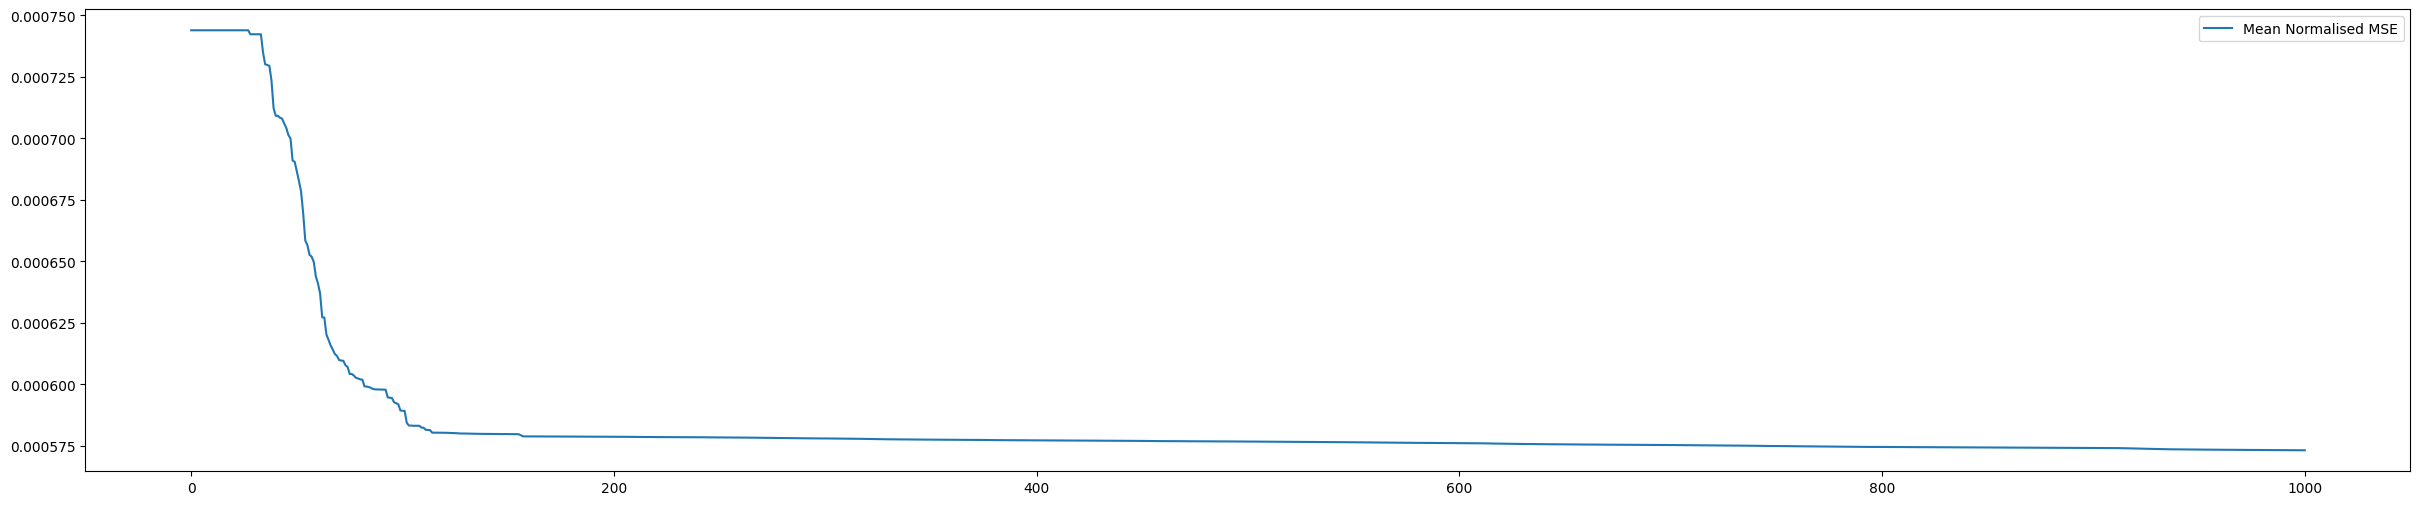

In [17]:
plt.figure(figsize=(30, 6))
# plt.plot(error_curve[:, 0])
plt.plot(error_curve[:, 1])
# plt.plot(error_curve[:, 2])
# plt.legend(["Best Normalised MSE", "Mean Normalised MSE", "Worst Normalised MSE"])
plt.legend(["Mean Normalised MSE"])
plt.show()

In [18]:
model = CFLANN(0.00025, optimiser.data[optimiser.best]['W'])
preds = model.forward_propagation(test_x)
print(preds.shape)

(108, 1)


In [19]:
preds[:, 0]

array([0.18862006, 0.19692603, 0.19025264, 0.20871856, 0.19381935,
       0.18472706, 0.1950674 , 0.19185661, 0.18020451, 0.18645326,
       0.1953752 , 0.19205285, 0.18360855, 0.21095143, 0.21030249,
       0.20701566, 0.21253268, 0.22129672, 0.22854705, 0.23338442,
       0.24897079, 0.30284565, 0.26567332, 0.33815159, 0.33806881,
       0.35591326, 0.34259156, 0.298234  , 0.33323759, 0.3546388 ,
       0.34069855, 0.33617882, 0.31945745, 0.34529383, 0.34385941,
       0.33193108, 0.40658493, 0.37938149, 0.39039588, 0.37630474,
       0.35949713, 0.38870357, 0.36434919, 0.39341566, 0.33181743,
       0.32403894, 0.33638606, 0.32549098, 0.34374612, 0.32520363,
       0.32389848, 0.35080814, 0.32796896, 0.35866174, 0.3535893 ,
       0.38843098, 0.39880383, 0.39547175, 0.43507787, 0.40180726,
       0.43111206, 0.43212064, 0.48599124, 0.50933977, 0.51411073,
       0.53669327, 0.57834981, 0.65803706, 0.52862491, 0.60633843,
       0.56419492, 0.53659685, 0.43967958, 0.50459372, 0.60836

In [21]:
E = (test_y.reset_index()[9] - preds[:, 0])
print("mse = " + str(np.mean(E**2)))
print("rmse = " + str(np.sqrt(np.mean(E**2))))
print("mae = " + str(np.mean(abs(E))))
print("mape = " + str(np.mean(abs(E)/test_y.reset_index()[9])))

mse = 0.0009965753155546095
rmse = 0.031568581145731106
mae = 0.021215478998157632
mape = 0.05162521722535428


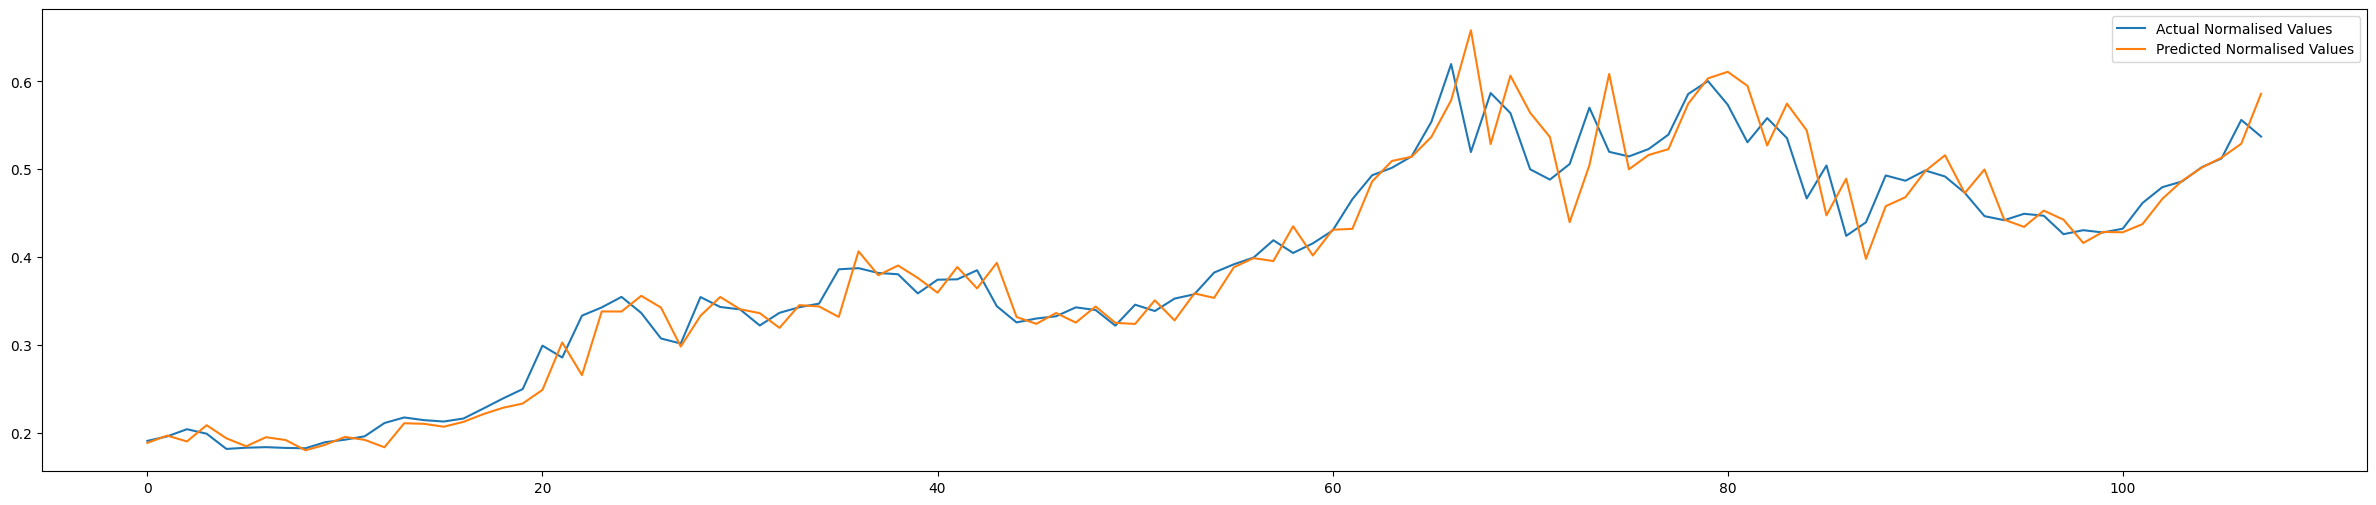

In [20]:
plt.figure(figsize=(30, 6))
plt.plot(test_y.reset_index()[9])
plt.plot(preds)
plt.legend(["Actual Normalised Values", "Predicted Normalised Values"])
plt.show()

In [22]:
d1 = (data1max - data1min + 2)[0]
print(type(d1))
denormalized_preds = (preds*d1)[:,0]
# print(denormalized_preds)
denormalized_preds += (data1min + 1)[0]
# print(denormalized_preds)
preds1 = pd.DataFrame(denormalized_preds)
preds1['DATE'] = data1.index[-1*len(preds1):]
preds1 = preds1.set_index('DATE')
print(preds1)

<class 'numpy.float64'>
                       0
DATE                    
2019-04-22   5258.943252
2019-04-23   5406.293111
2019-04-24   5287.905572
2019-04-25   5615.495337
2019-04-26   5351.179771
...                  ...
2019-08-03  10546.193630
2019-08-04  10815.176021
2019-08-05  11015.406789
2019-08-06  11296.517902
2019-08-07  12304.332108

[108 rows x 1 columns]


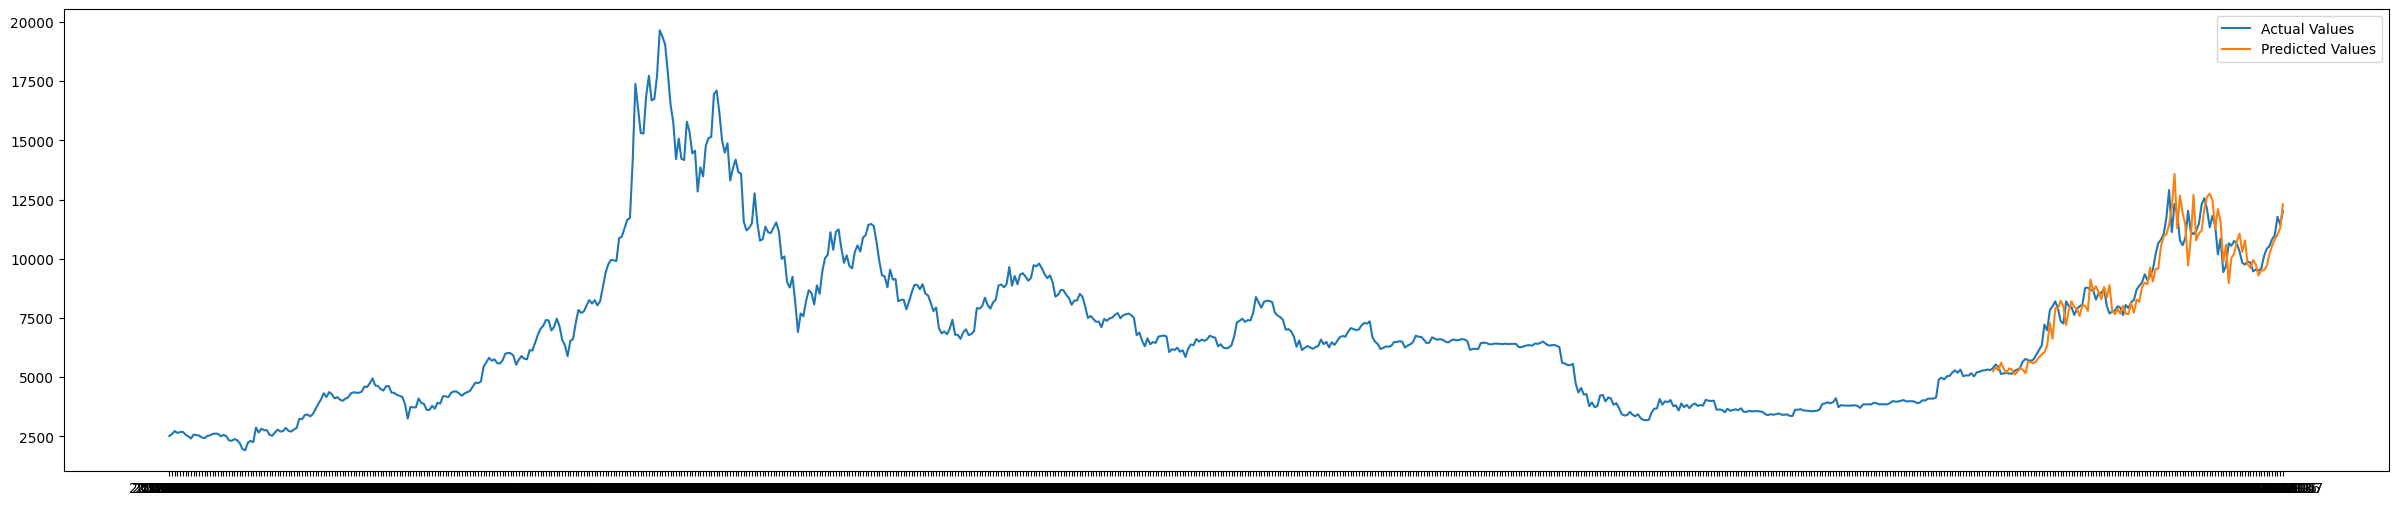

In [23]:
plt.figure(figsize=(30, 6))
plt.plot(data1)
plt.plot(preds1)
plt.legend(["Actual Values", "Predicted Values"])
plt.show()

In [24]:
mse = np.mean((np.array(preds1[0]) - np.array(data1.iloc[-1*(len(preds1)):, 0]))**2)
print("mse  "+ str(mse))
print("rmse "+ str(np.sqrt(mse)))

mse  480406.68138678843
rmse 693.1137578974958
